<a href="https://colab.research.google.com/github/CAPP30255-Project/DepressionDetection/blob/master/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
ROOT = '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import torch
from os.path import join 
repo_dir = '/content/drive/MyDrive/Repos/DepressionDetection'

In [3]:
data_dir = repo_dir + '/data/Suicide_Detection.csv'

In [4]:
%cd "{repo_dir}"
#%pip install -r jj_dt_project_requirements.txt
#!pip install torchtext==0.12.0

/content/drive/MyDrive/Repos/DepressionDetection


In [5]:
!git pull

Already up to date.


In [6]:
from data.data_process import *
from _core.bow_classifier import *
from _core.cnn_model import *

In [7]:
depression_data = dep_data(data_dir, tokenizer = "split")

In [8]:
depression_data.split_data(123)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [29]:
BATCH_SIZE = 64
using_GPU = True

# Using Glove, split function

In [30]:
from torchtext import vocab

glove = vocab.GloVe('6B')

In [31]:
def bow_classifier2(data):
    counter = Counter()
    for (line, label) in data:
        counter.update(line)
    vocab = v(counter, specials = ['<unk>'], special_first = True, min_freq = 1000)
    return vocab, counter

In [32]:
from torchtext.vocab import vocab as v
vocab_words, counter = bow_classifier2(depression_data.all_data)
vocab_words.set_default_index(0)
glove_vector = glove.get_vecs_by_tokens(vocab_words.get_itos())

In [33]:
def collate_fn(batch):
    vectors = torch.zeros(len(batch), len(vocab_words))
    label_mapping = {'non-suicide': 0, 'suicide': 1}
    labels = []
    for index, example in enumerate(batch):
      indexes = vocab_words(example[0])
      for w_idx in indexes:
        vectors[index, int(w_idx)] = 1
      labels.append(label_mapping.get(example[1]))
    labels = torch.tensor(labels)
    return  vectors.cuda(), labels.cuda()

In [34]:
train_dataloader = DataLoader(depression_data.train, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
val_dataloader = DataLoader(depression_data.val, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(depression_data.test, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

Start training...

------------------------------------------------------------
step 0 | loss 0.705
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.484
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1500 | loss 0.528
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 2000 | loss 0.539
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
New best model saved!
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
   1    |   0.568844   |  0.541773  |   73.65   |  340.56  
step 0 | loss 0.519
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.561
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.398
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1500 | loss 0.605
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 2000 | loss 0.485
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
New best model saved!
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
   2    |   0.554379   |  0.541284  |   73.71   |  340.84  
step 0 | loss 0.618
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.65
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ste

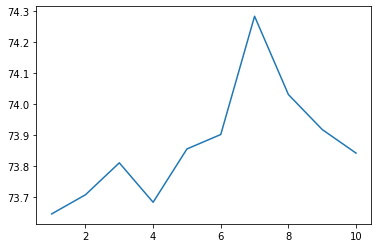

In [35]:
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(vocab_words),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5,
                                      pretrained_embedding = glove_vector)
train(model = cnn_rand, optimizer = optimizer, 
      train_dataloader = train_dataloader, 
      val_dataloader = val_dataloader, epochs=10, log_interval = 500,
      save_best = "/content/drive/MyDrive/Repos/DepressionDetection/output/CNN_glove_split_best.pt")

# Using BoW

In [12]:
depression_data = dep_data(data_dir, tokenizer = "split")

In [13]:
depression_data.split_data(123)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [14]:
BATCH_SIZE = 64
using_GPU = True

In [15]:
vocab_words, counter = bow_classifier(depression_data.all_data)

In [16]:
def collate_into_bow_cnn(batch, device = DEVICE):
    labels = [0] * len(batch)
    vectors = torch.zeros(len(batch), len(vocab_words))
    for index, (words, label) in enumerate(batch):
        labels[index] = LABEL_MAPPINGS[label]
        for word in words:
            index_word = vocab_words[word]    
            vectors[index, int(index_word)] += 1 / len(words)     
    labels = torch.tensor(labels)
    return vectors.to(device), labels.to(device)

In [17]:
train_dataloader = DataLoader(depression_data.train, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow_cnn)
val_dataloader = DataLoader(depression_data.val, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow_cnn)
test_dataloader = DataLoader(depression_data.test, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow_cnn)

In [18]:
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(vocab_words),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5,
                                      pretrained_embedding = None)


Start training...

------------------------------------------------------------
step 0 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.696
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1500 | loss 0.686
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 2000 | loss 0.686
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
New best model saved!
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
   1    |   0.692778   |  0.692973  |   50.34   |  625.65  
step 0 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.69
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1500 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 2000 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
   2    |   0.692736   |  0.692737  |   49.78   |  618.34  
step 0 | loss 0.694
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.695
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.694


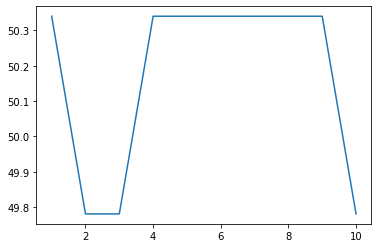

In [20]:
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(vocab_words),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5,
                                      pretrained_embedding = None)
train(model = cnn_rand, optimizer = optimizer, 
      train_dataloader = train_dataloader, 
      val_dataloader = val_dataloader, epochs=10, log_interval = 500,
      save_best = "/content/drive/MyDrive/Repos/DepressionDetection/output/CNN_bow_best.pt")

# TF-IDF

In [11]:
def collate_fn_tfidf(batch):
  tf_idf_matrix = torch.zeros(len(batch), tf_idf.shape[1])
  labels = []
  for i, (index, text, label) in enumerate(batch):
    tf_idf_matrix[i] = tf_idf[index]
    labels.append(label)
  return tf_idf_matrix.to("cuda"), torch.tensor(labels).to("cuda")

In [12]:
depression_data = dep_data(data_dir, pandas = True)

In [13]:
depression_data.split_data(123, pandas = True)

In [14]:
tf_idf, labels = create_tf_idf(depression_data.all_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
depression_data.train["class"] = depression_data.train["class"].map(LABEL_MAPPINGS)
depression_data.val["class"] = depression_data.val["class"].map(LABEL_MAPPINGS)

In [16]:
train_dataloader = DataLoader(depression_data.train.values.tolist(), batch_size=64,
                              shuffle=True, 
                              collate_fn=collate_fn_tfidf)
val_dataloader = DataLoader(depression_data.val.values.tolist(), batch_size=64,
                              shuffle=True, 
                              collate_fn=collate_fn_tfidf)

Start training...

------------------------------------------------------------
step 0 | loss 0.696
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.691
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.683
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1500 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 2000 | loss 0.686
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
New best model saved!
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
   1    |   0.690084   |  0.690256  |   50.89   |  215.24  
step 0 | loss 0.686
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.692
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.694
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1500 | loss 0.694
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 2000 | loss 0.683
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
   2    |   0.690143   |  0.690481  |   50.87   |  214.20  
step 0 | loss 0.685
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 500 | loss 0.693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
step 1000 | loss 0.683

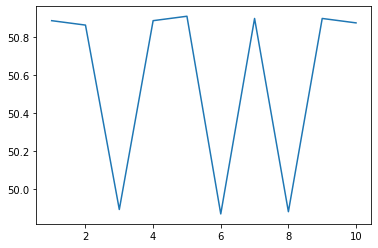

In [22]:
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(tf_idf),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5,
                                      pretrained_embedding = None)
train(model = cnn_rand, optimizer = optimizer, 
      train_dataloader = train_dataloader, 
      val_dataloader = val_dataloader, epochs=10, log_interval = 500,
      save_best = "/content/drive/MyDrive/Repos/DepressionDetection/output/CNN_tf_idf_best.pt")